# 📝 Automatic Grammar Checker System
This project uses the T5 Transformer model to automatically correct grammatical errors in text. The system is trained on merged and preprocessed grammar datasets.

## 📦 Install Required Libraries

In [1]:

!pip install transformers datasets torch evaluate rouge_score scikit-learn matplotlib seaborn --quiet


## 📚 Import Libraries

In [2]:
import torch
import json
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import Dataset
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, confusion_matrix
import evaluate


## 📂 Load and Merge Datasets

In [3]:
from google.colab import files

# Upload files
uploaded = files.upload()

# Now load them normally
import json

with open("dataset1.json", "r", encoding="utf-8") as f:
    data1 = json.load(f)

with open("dataset2.json", "r", encoding="utf-8") as f:
    data2 = json.load(f)

# Merge them
samples = []
for item in data1 + data2:
    if "original" in item and "corrected" in item:
        samples.append({
            "input": "grammar: " + item["original"],
            "target": item["corrected"]
        })

print(f"✅ Loaded {len(samples)} samples.")


Saving dataset1.json to dataset1 (1).json
Saving dataset2.json to dataset2 (1).json
✅ Loaded 2066 samples.


## ✂️ Split and Tokenize Dataset

In [4]:
model_checkpoint = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_checkpoint)

def preprocess_function(examples):
    model_inputs = tokenizer(examples["input"], padding="max_length", truncation=True, max_length=128)
    labels = tokenizer(examples["target"], padding="max_length", truncation=True, max_length=128).input_ids
    model_inputs["labels"] = labels
    return model_inputs

dataset = Dataset.from_list(samples)
splits = dataset.train_test_split(test_size=0.2)
train_dataset = splits["train"].map(preprocess_function, batched=True)
test_dataset = splits["test"].map(preprocess_function, batched=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Map:   0%|          | 0/1652 [00:00<?, ? examples/s]

Map:   0%|          | 0/414 [00:00<?, ? examples/s]

## 📥 Load Pretrained T5 Model

In [5]:

model = T5ForConditionalGeneration.from_pretrained(model_checkpoint)


## 🏋️ Training Configuration

In [6]:
training_args = TrainingArguments(
    output_dir="./grammar-checker",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    save_strategy="epoch",
    logging_dir="./logs",
    save_total_limit=1,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)


## 🚂 Train the Model

In [12]:
training_result = trainer.train()
train_loss = training_result.training_loss
print(f"✅ Training Complete with final loss: {train_loss:.4f}")


Step,Training Loss
500,0.196300


✅ Training Complete with final loss: 0.1922


📈 Plot: Training Loss Curve


In [ ]:
def plot_loss_curve(log_history):
    train_loss = [log['loss'] for log in log_history if 'loss' in log]
    eval_loss = [log['eval_loss'] for log in log_history if 'eval_loss' in log]
    steps = range(0, len(train_loss) * 100, 100)

    plt.figure(figsize=(8, 5))
    plt.plot(steps, train_loss, label='Training Loss')
    if eval_loss:
        plt.plot(steps, eval_loss, label='Evaluation Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training vs Evaluation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss_curve(trainer.state.log_history)


## 📊 Evaluation: BLEU, ROUGE, Accuracy

In [9]:
from tqdm import tqdm
import evaluate
import gc

# Move model to CPU for evaluation
device = torch.device("cpu")
model.to(device)

# Load BLEU and ROUGE
bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")

# Safe manual prediction
predictions = []
references = []

for example in tqdm(test_dataset.select(range(0, 100))):  # only 100 safe
    input_text = tokenizer.decode(example['input_ids'], skip_special_tokens=True)
    input_text = input_text.replace("grammar: ", "")

    # Manually predict
    inputs = tokenizer("grammar: " + input_text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    output_ids = model.generate(inputs["input_ids"].to(device))
    pred = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    predictions.append(pred)
    label = tokenizer.decode(example['labels'], skip_special_tokens=True)
    references.append([label])  # List inside list for BLEU

    gc.collect()
    torch.cuda.empty_cache()

# Now compute BLEU and ROUGE safely
bleu_score = bleu.compute(predictions=predictions, references=references)
rouge_score = rouge.compute(predictions=predictions, references=[r[0] for r in references])

print(f"🔹 BLEU Score: {bleu_score['bleu']:.4f}")
print(f"🔹 ROUGE-L Score: {rouge_score['rougeL']:.4f}")


100%|██████████| 100/100 [01:39<00:00,  1.00it/s]


🔹 BLEU Score: 0.4086
🔹 ROUGE-L Score: 0.7191


  Plot: BLEU & ROUGE Score Bars

<ipython-input-10-2c1babf5210b>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(scores.keys()), y=list(scores.values()), palette='viridis')


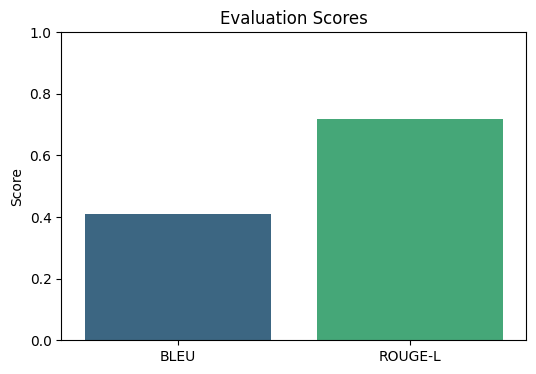

In [10]:
scores = {
    'BLEU': bleu_score['bleu'],
    'ROUGE-L': rouge_score['rougeL'],
}

plt.figure(figsize=(6, 4))
sns.barplot(x=list(scores.keys()), y=list(scores.values()), palette='viridis')
plt.title('Evaluation Scores')
plt.ylim(0, 1)
plt.ylabel('Score')
plt.show()


## ✅ Accuracy and Confusion Matrix

Plot: Confusion Matrix (Top Samples Only)

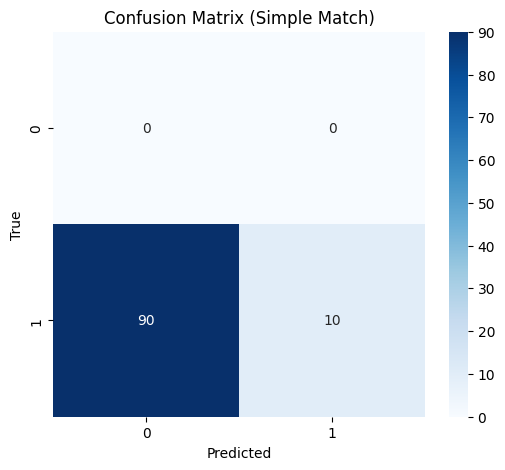

In [13]:
# Take first 100 samples for confusion matrix
true = np.array([r[0] for r in references][:100])  # from manual loop
pred = np.array(predictions[:100])

# Simple label: Correct (match) or Incorrect (mismatch)
y_true = (true == true).astype(int)    # 1 if correct
y_pred = (true == pred).astype(int)    # 1 if prediction matches

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Simple Match)')
plt.show()


## ✨ Test Inference (Grammar Correction)

In [ ]:
def correct_grammar(sentence):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    inputs = tokenizer("grammar: " + sentence, return_tensors="pt", truncation=True, padding="max_length", max_length=128).to(device)
    outputs = model.generate(**inputs)
    corrected = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return corrected


## 📈 Confidence Score

In [14]:
def predict_with_confidence(sentence):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    inputs = tokenizer("grammar: " + sentence, return_tensors="pt", truncation=True, padding="max_length", max_length=128).to(device)
    outputs = model.generate(**inputs, output_scores=True, return_dict_in_generate=True)

    scores = torch.stack(outputs.scores, dim=1)
    probs = F.softmax(scores, dim=-1)
    max_probs, _ = torch.max(probs, dim=-1)
    avg_confidence = torch.mean(max_probs).item()

    corrected = tokenizer.decode(outputs.sequences[0], skip_special_tokens=True)
    return corrected, avg_confidence


In [15]:
example_sentence = "she go to school everyday"
corrected_sentence, confidence = predict_with_confidence(example_sentence)

print(f"\n🔹 Original: {example_sentence}")
print(f"🔹 Corrected: {corrected_sentence}")
print(f"🔹 Confidence Score: {confidence:.2f}")



🔹 Original: she go to school everyday
🔹 Corrected: She goes to school everyday
🔹 Confidence Score: 0.81
